In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
carseats = pd.read_csv("Carseats.csv")
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [14]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder

In [9]:
label_encoder = LabelEncoder()

carseats['ShelveLoc'] = label_encoder.fit_transform(carseats['ShelveLoc'])
carseats['Urban'] = label_encoder.fit_transform(carseats['Urban'])
carseats['US'] = label_encoder.fit_transform(carseats['US'])

In [10]:
X = carseats.drop(columns=['Sales'])
y = carseats['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (320, 10)
Test set size: (80, 10)


In [5]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error

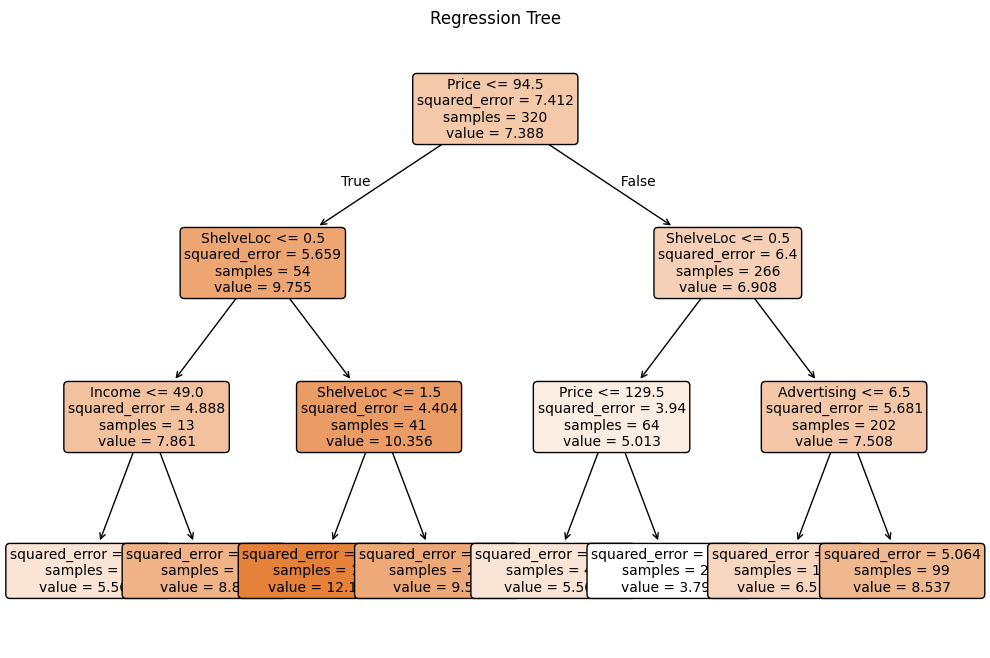

Test MSE: 5.9653694023930175


In [11]:
tree_reg = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(tree_reg, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.title("Regression Tree")
plt.show()

y_pred = tree_reg.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)

print(f"Test MSE: {test_mse}")

There are significantly more samples (266) that are larger than 94.5 than those that are smaller (54). However, the numbers that are smaller than 94.5 have a much higher average value (9.755 to 6.908).

Optimal tree depth: 8


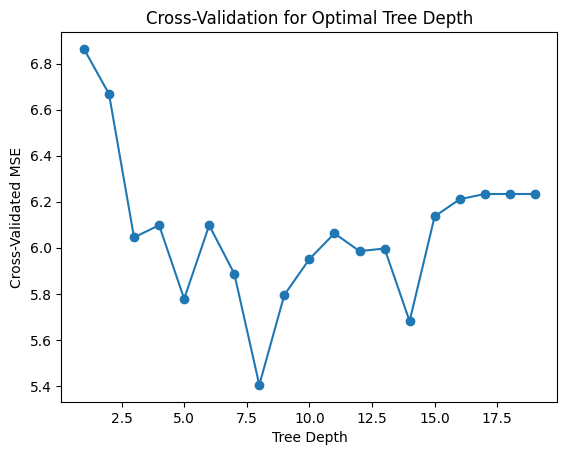

Test MSE with pruned tree: 6.367386337257309
Test MSE with unpruned tree: 5.51592875


In [15]:
max_depths = range(1, 20)
cv_scores = []

for max_depth in max_depths:
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    scores = cross_val_score(tree, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    mean_score = -np.mean(scores)  # Convert back to positive MSE
    cv_scores.append(mean_score)

optimal_depth = max_depths[np.argmin(cv_scores)]
print(f"Optimal tree depth: {optimal_depth}")

plt.plot(max_depths, cv_scores, marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Cross-Validated MSE')
plt.title('Cross-Validation for Optimal Tree Depth')
plt.show()

pruned_tree = DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)
pruned_tree.fit(X_train, y_train)

y_pred_pruned = pruned_tree.predict(X_test)
test_mse_pruned = mean_squared_error(y_test, y_pred_pruned)
print(f"Test MSE with pruned tree: {test_mse_pruned}")

unpruned_tree = DecisionTreeRegressor(random_state=42)
unpruned_tree.fit(X_train, y_train)
y_pred_unpruned = unpruned_tree.predict(X_test)
test_mse_unpruned = mean_squared_error(y_test, y_pred_unpruned)
print(f"Test MSE with unpruned tree: {test_mse_unpruned}")

The pruned tree actually has a higher MSE, unfortunately.

In [16]:
from sklearn.ensemble import BaggingRegressor

In [18]:
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=100,
    random_state=42,
    oob_score=True,
    n_jobs=-1
)
bagging_model.fit(X_train, y_train)

y_pred = bagging_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE with Bagging: {test_mse}")

feature_importances = np.mean(
    [tree.feature_importances_ for tree in bagging_model.estimators_], axis=0
)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

Test MSE with Bagging: 3.1615284669999992

Feature Importance:
       Feature  Importance
4        Price    0.308741
5    ShelveLoc    0.232767
6          Age    0.125491
2  Advertising    0.102984
0    CompPrice    0.095486
1       Income    0.051386
3   Population    0.039170
7    Education    0.033290
8        Urban    0.005569
9           US    0.005117


Price is the most important variable, with US being the least important. I love this feature; it is very insightful!

In [19]:
from sklearn.ensemble import RandomForestRegressor

Test MSE with Random Forests: 4.358947731124997

Feature Importance:
       Feature  Importance
4        Price    0.247989
5    ShelveLoc    0.178796
6          Age    0.136939
2  Advertising    0.107062
0    CompPrice    0.088955
1       Income    0.087707
3   Population    0.076321
7    Education    0.050113
9           US    0.015546
8        Urban    0.010573


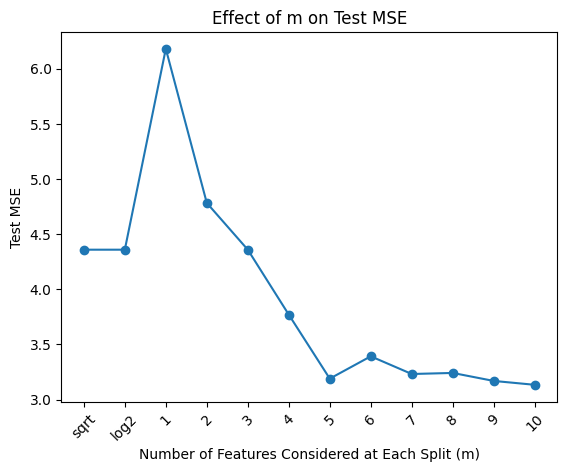

In [21]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_features='sqrt'
)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE with Random Forests: {test_mse}")

feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

max_features_options = ['sqrt', 'log2'] + list(range(1, X.shape[1] + 1))
mse_values = []

for m in max_features_options:
    rf = RandomForestRegressor(n_estimators=100, random_state=42, max_features=m)
    rf.fit(X_train, y_train)
    y_pred_m = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_m)
    mse_values.append(mse)

plt.plot(max_features_options, mse_values, marker='o')
plt.xlabel('Number of Features Considered at Each Split (m)')
plt.ylabel('Test MSE')
plt.title('Effect of m on Test MSE')
plt.xticks(rotation=45)
plt.show()

This was another very nice predictor model. This one also had price as the most important predictor, but had Urban with slightly less importance than US.

In [22]:
oj = pd.read_csv('OJ.csv')
oj.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [31]:
X = oj.drop(columns=['Purchase'])
y = oj['Purchase']

train_size = 800

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 800
Test set size: 270


In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [33]:
oj = oj.drop(columns=['Store7'])

KeyError: "['Store7'] not found in axis"

In [34]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_error_rate = 1 - train_accuracy

print(f"Training error rate: {train_error_rate:.4f}")

Training error rate: 0.0075


In [38]:
from sklearn.tree import plot_tree, export_text

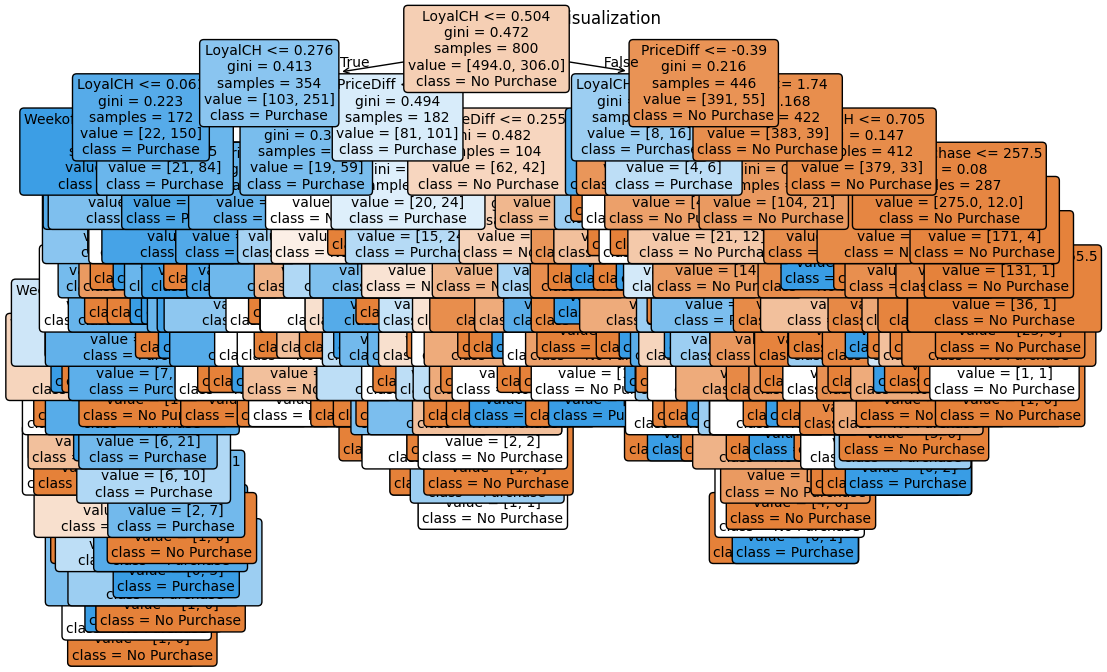

Number of terminal nodes (leaf nodes) in the tree: 163


In [37]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=['No Purchase', 'Purchase'], rounded=True, fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()

n_terminal_nodes = tree_model.tree_.n_leaves
print(f"Number of terminal nodes (leaf nodes) in the tree: {n_terminal_nodes}")

In [39]:
tree_text = export_text(tree_model, feature_names=list(X.columns))
print(tree_text)

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- WeekofPurchase <= 268.50
|   |   |   |   |--- class: MM
|   |   |   |--- WeekofPurchase >  268.50
|   |   |   |   |--- SalePriceMM <= 2.15
|   |   |   |   |   |--- class: MM
|   |   |   |   |--- SalePriceMM >  2.15
|   |   |   |   |   |--- class: CH
|   |   |--- LoyalCH >  0.06
|   |   |   |--- LoyalCH <= 0.21
|   |   |   |   |--- WeekofPurchase <= 273.00
|   |   |   |   |   |--- WeekofPurchase <= 261.00
|   |   |   |   |   |   |--- PriceDiff <= -0.13
|   |   |   |   |   |   |   |--- PriceCH <= 1.81
|   |   |   |   |   |   |   |   |--- WeekofPurchase <= 236.50
|   |   |   |   |   |   |   |   |   |--- WeekofPurchase <= 234.00
|   |   |   |   |   |   |   |   |   |   |--- LoyalCH <= 0.16
|   |   |   |   |   |   |   |   |   |   |   |--- class: MM
|   |   |   |   |   |   |   |   |   |   |--- LoyalCH >  0.16
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |

In [40]:
from sklearn.metrics import confusion_matrix

In [41]:
y_test_pred = tree_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

accuracy = accuracy_score(y_test, y_test_pred)
test_error_rate = 1 - accuracy
print(f"Test error rate: {test_error_rate:.4f}")

Confusion Matrix:
[[121  38]
 [ 38  73]]
Test error rate: 0.2815


In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
param_grid = {'max_depth': [3, 5, 7, 10, None]}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_max_depth = grid_search.best_params_['max_depth']
print(f"Optimal tree size (max_depth): {best_max_depth}")

optimal_tree_model = grid_search.best_estimator_

y_test_pred = optimal_tree_model.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
test_error_rate = 1 - accuracy
print(f"Test error rate with optimal tree size: {test_error_rate:.4f}")

Optimal tree size (max_depth): 5
Test error rate with optimal tree size: 0.2593


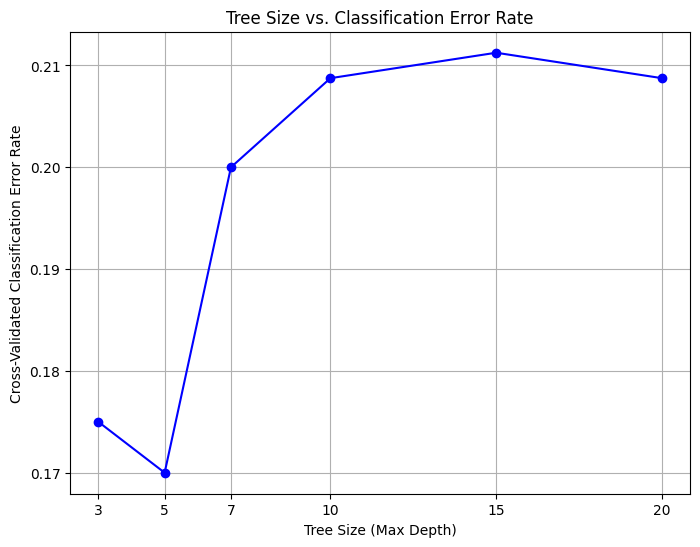

In [45]:
tree_depths = [3, 5, 7, 10, 15, 20]

error_rates = []

for max_depth in tree_depths:
    tree_model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    
    cv_scores = cross_val_score(tree_model, X_train, y_train, cv=5, scoring='accuracy')
    
    error_rate = 1 - np.mean(cv_scores)
    error_rates.append(error_rate)

plt.figure(figsize=(8, 6))
plt.plot(tree_depths, error_rates, marker='o', linestyle='-', color='b')
plt.xlabel("Tree Size (Max Depth)")
plt.ylabel("Cross-Validated Classification Error Rate")
plt.title("Tree Size vs. Classification Error Rate")
plt.grid(True)
plt.xticks(tree_depths)
plt.show()

In [47]:
best_max_depth = tree_depths[np.argmin(error_rates)]
best_error_rate = np.min(error_rates)
best_max_depth

5

In [48]:
best_error_rate

np.float64(0.16999999999999993)

The tree with the depth of 5 has the lowest error rate at 0.169.

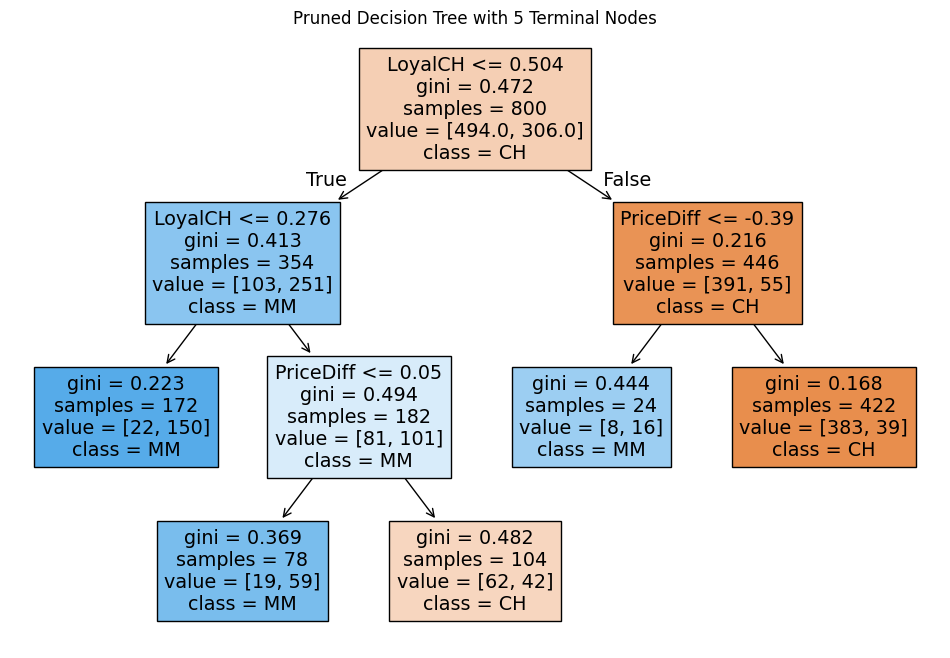

Number of terminal nodes in the pruned tree: 5


In [51]:
class_names = np.unique(y)

pruned_tree = DecisionTreeClassifier(max_depth=best_max_depth, max_leaf_nodes=5, random_state=42)
pruned_tree.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(pruned_tree, filled=True, feature_names=X.columns, class_names=class_names)
plt.title("Pruned Decision Tree with 5 Terminal Nodes")
plt.show()

num_terminal_nodes = pruned_tree.get_n_leaves()
print(f"Number of terminal nodes in the pruned tree: {num_terminal_nodes}")

In [53]:
unpruned_tree = DecisionTreeClassifier(max_depth=best_max_depth, random_state=42)
unpruned_tree.fit(X, y)

unpruned_train_accuracy = accuracy_score(y, unpruned_tree.predict(X))
unpruned_train_error_rate = 1 - unpruned_train_accuracy
print(f"Training error rate for the unpruned tree: {unpruned_train_error_rate:.4f}")

pruned_tree = DecisionTreeClassifier(max_depth=best_max_depth, max_leaf_nodes=5, random_state=42)
pruned_tree.fit(X, y)

pruned_train_accuracy = accuracy_score(y, pruned_tree.predict(X))
pruned_train_error_rate = 1 - pruned_train_accuracy
print(f"Training error rate for the pruned tree: {pruned_train_error_rate:.4f}")

if pruned_train_error_rate > unpruned_train_error_rate:
    print("The unpruned tree has a lower training error rate.")
else:
    print("The pruned tree has a lower training error rate.")

Training error rate for the unpruned tree: 0.1336
Training error rate for the pruned tree: 0.1766
The unpruned tree has a lower training error rate.


In [54]:
unpruned_tree = DecisionTreeClassifier(max_depth=best_max_depth, random_state=42)
unpruned_tree.fit(X_train, y_train)

unpruned_test_accuracy = accuracy_score(y_test, unpruned_tree.predict(X_test))
unpruned_test_error_rate = 1 - unpruned_test_accuracy
print(f"Test error rate for the unpruned tree: {unpruned_test_error_rate:.4f}")

pruned_tree = DecisionTreeClassifier(max_depth=best_max_depth, max_leaf_nodes=5, random_state=42)
pruned_tree.fit(X_train, y_train)

pruned_test_accuracy = accuracy_score(y_test, pruned_tree.predict(X_test))
pruned_test_error_rate = 1 - pruned_test_accuracy
print(f"Test error rate for the pruned tree: {pruned_test_error_rate:.4f}")

# Compare the test error rates
if pruned_test_error_rate > unpruned_test_error_rate:
    print("The unpruned tree has a lower test error rate.")
else:
    print("The pruned tree has a lower test error rate.")

Test error rate for the unpruned tree: 0.2593
Test error rate for the pruned tree: 0.1926
The pruned tree has a lower test error rate.
